# Historic Temperature Maps for Brazil

### Reconstructing average temperature maps using Tensorflow Probability

In [37]:
import pandas as pd
import geopandas as gp
import lib.pg_temperatura as pg
import lib.pg_brasil as br
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import numpy as np
from sqlalchemy import extract, func, tuple_
from lib.gpr_estimator import GPREstimator

warnings.filterwarnings('ignore')

plt.style.use('dark_background')

In [3]:
altitude_q = pg.session.query(pg.Altitude)
altitude_pd = pd.read_sql(altitude_q.statement, pg.connect)
altitude_gp = gp.GeoDataFrame(
    altitude_pd, 
    geometry=gp.points_from_xy(altitude_pd.longitude, altitude_pd.latitude)
)

station_pd = pd.read_sql(
    (
        pg.session
        .query(pg.Estacao)
        .filter(pg.Estacao.cd_estacao.like('8%'))
        .statement
    ), 
    pg.connect
)

station_gp = gp.GeoDataFrame(
    station_pd, 
    geometry=gp.points_from_xy(
        station_pd.vl_longitude,
        station_pd.vl_latitude
    )
)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    return (
        colors
        .LinearSegmentedColormap
        .from_list(
            f'trunc({cmap.name},{minval:.2f},{minval:.2f})',
            cmap(np.linspace(minval, maxval, n))
        )
    )


cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.25, 1)


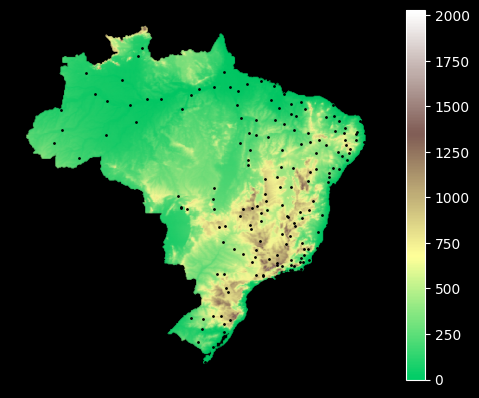

In [4]:
%matplotlib inline

ax = altitude_gp.plot(
    column='altitude', legend=True, markersize=.1, cmap=new_cmap
)
ax = station_gp.plot(ax=ax, markersize=1, facecolor='black')
of = plt.axis('off')
plt.savefig('out/topo_map.png')

This topographic map depicts the geographic coordinates for 170 climate data collection stations spread through Brazil. 
The data for these stations (available [here](https://tempo.inmet.gov.br/TabelaEstacoes)) goes back to the 1960's in some cases.
I have written an API for collecting this data using JavaScript and puppeteer, a Google library for browser automation.

In [5]:
def build_season_tuples():
    year = 1999
    seasons_range = {
        'fall': pd.date_range(
            start=f'21/03/{year}', end=f'20/06/{year}'
        ),
        'winter': pd.date_range(
            start=f'21/06/{year}', end=f'22/09/{year}'
        ),
        'spring': pd.date_range(
            start=f'23/09/{year}', end=f'20/12/{year}'
        ),
        'summer': pd.date_range(
            start=f'21/12/{year}', end=f'20/03/{year+1}'
        ),
        'year': pd.date_range(
            start=f'01/01/{year+1}', end=f'31/12/{year+1}'
        )
    }
    seasons_tuples = {}
    for k, dates in seasons_range.items():
        this_season = []
        for date in dates:
            this_season.append((date.month, date.day))
        seasons_tuples[k] = this_season

    return seasons_tuples


ranges = build_season_tuples()

In order to use the point observations from these stations to estimate temperature maps for the entire brazilian territory,
here I used Gaussian Process Regression.
The temperature observations from stations along their coordinates (longitude, latitude, and altitude) are used to estimate 
kernel parameters.
Here I used average temperatures over each year, as measured at 12PM local time, thus estimating different kernel parameters for each year.


Then, using a coordinate grid that describe the topography of Brazil (available [here](http://www.dsr.inpe.br/topodata/data/txt/)), 
I sample a posterior distribution of average temperatures for each grid point using these estimated parameters.
The moments of these distributions (mean and standard deviation) can then be used to draw estimated temperature maps for each year and to evaluate these estimates.

I implemented all steps in constructing and estimating kernel parameters as well as sampling posterior distributions in a single Python class that can be obtained [here](https://github.com/ggarciapato/temperatura/blob/main/lib/gpr_estimator.py).
In order to estimate kernel parameter estimates for each year, I used stochastic gradient descent as implemented in the Adam optimizer from Tensorflow, with a learning rate of 0.1 and 1000 iterations.


In [6]:
year_extractor = extract('year', pg.Registro.data).label('year')

seasons_pds = []

for season, range in ranges.items():
    means_q = (
        pg.session.query(
            pg.Estacao.dc_nome, 
            pg.Estacao.cd_estacao,
            pg.Estacao.vl_longitude, 
            pg.Estacao.vl_latitude, 
            pg.Estacao.vl_altitude,
            year_extractor,
            func.avg(pg.Registro.temperatura_C).label(f'{season}_mean'),
            func.min(pg.Registro.temperatura_C).label(f'{season}_min'),
            func.max(pg.Registro.temperatura_C).label(f'{season}_max'),
            func.percentile_cont(0.5).within_group(
                pg.Registro.temperatura_C
            ).label(f'{season}_median')
        )
        .join(pg.Estacao._registros)
        .filter(
            pg.Estacao.cd_estacao.like('8%'),
            pg.Registro.temperatura_C != np.nan,
            tuple_(
                extract('month', pg.Registro.data), 
                extract('day', pg.Registro.data)
            ).in_(range),
            pg.Registro.hora_utc == '1200'
        )
        .group_by(
            pg.Estacao.dc_nome, 
            pg.Estacao.cd_estacao,
            pg.Estacao.vl_longitude, 
            pg.Estacao.vl_latitude, 
            pg.Estacao.vl_altitude,
            year_extractor
        )
        .order_by(pg.Estacao.cd_estacao, year_extractor)
    )

    means_pd = pd.read_sql(means_q.statement, pg.connect)
    seasons_pds.append(means_pd)

seasons_pd = pd.concat(
    [df.set_index(list(df.columns[:6])) for df in seasons_pds], 
    axis=1
)

seasons_pd.to_csv('data/range_by_year.csv', index=True)

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


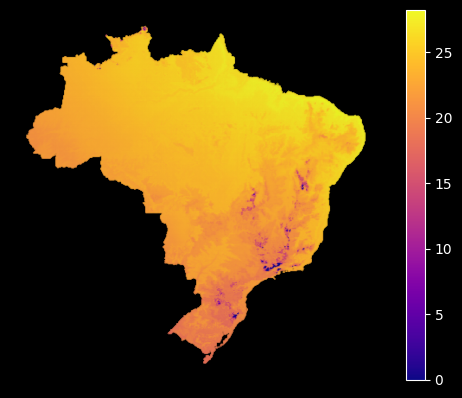

In [7]:
seasons_pd = pd.read_csv('data/range_by_year.csv')
seasons_pd = seasons_pd.set_index(list(seasons_pd.columns[:6]))
year_test = seasons_pd[seasons_pd.index.get_level_values('year') == 1999]

gp_estimator = GPREstimator(year_test)
gp_estimator.optimize(num_iters=1000)
grid = altitude_pd[['longitude', 'latitude', 'altitude']].to_numpy()

gp_estimator.predict(grid)
mapa_gp = gp.GeoDataFrame(
    data=gp_estimator.estimates,
    geometry=gp.points_from_xy(
        gp_estimator.estimates['vl_longitude'], 
        gp_estimator.estimates['vl_latitude']
    )
)

ax = mapa_gp.plot(
    column='year_mean_estimate', legend=True, markersize=.1, cmap='plasma'
)
of = plt.axis('off')
plt.savefig('out/test_estimate.png')

This map shows posterior mean estimates for grid coordinates in the year of 1999. 
Every temperature scale depicted here is in Celsius degrees.
Comparing this estimate with the topographic map, notice that higher altitudes have lower average temperatures.

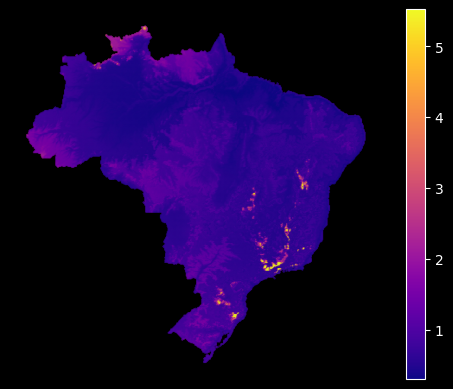

In [8]:
ax = mapa_gp.plot(
    column='year_mean_sdev', legend=True, markersize=.1, cmap='plasma'
)
of = plt.axis('off')
plt.savefig('out/test_deviations.png')

However, by observing posterior standard deviations on this map, 
we also observe that higher altitudes have wider posterior distributions, 
which indicates that these estimates are less precise.
This is probably due to the rarity of these altitudes in brazilian topography.

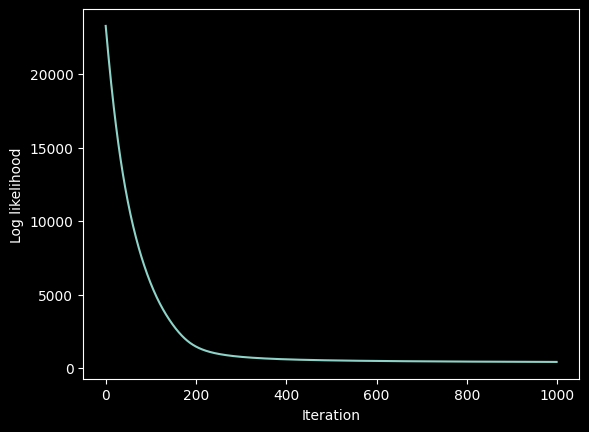

In [15]:
gp_estimator.plot_loglik()

This plot depicts the log-likelihood along iterations of the optimization process for this particular year.
The optimization procedure for other years is well-behaved in the same manner.

In [ ]:
#  lets estimate different regressions by year
_gprs = {}
_pds = []

for year, df in seasons_pd.groupby(level=5):
    # print(year, end='\n' if not year % 10 else ' ')
    estimator = GPREstimator(df)
    estimator.optimize(num_iters=1000)
    estimator.predict(grid)
    _gprs[year] = estimator
    y_pd = estimator.estimates.set_index(
        list(estimator.estimates.columns[:3])
    )
    y_pd = y_pd.rename(columns=lambda x: f'{x}_{int(year)}')
    _pds.append(y_pd)

years_pd = pd.concat(_pds, axis=1)

years_pd.to_csv('data/yearly_estimates.csv', index=True)

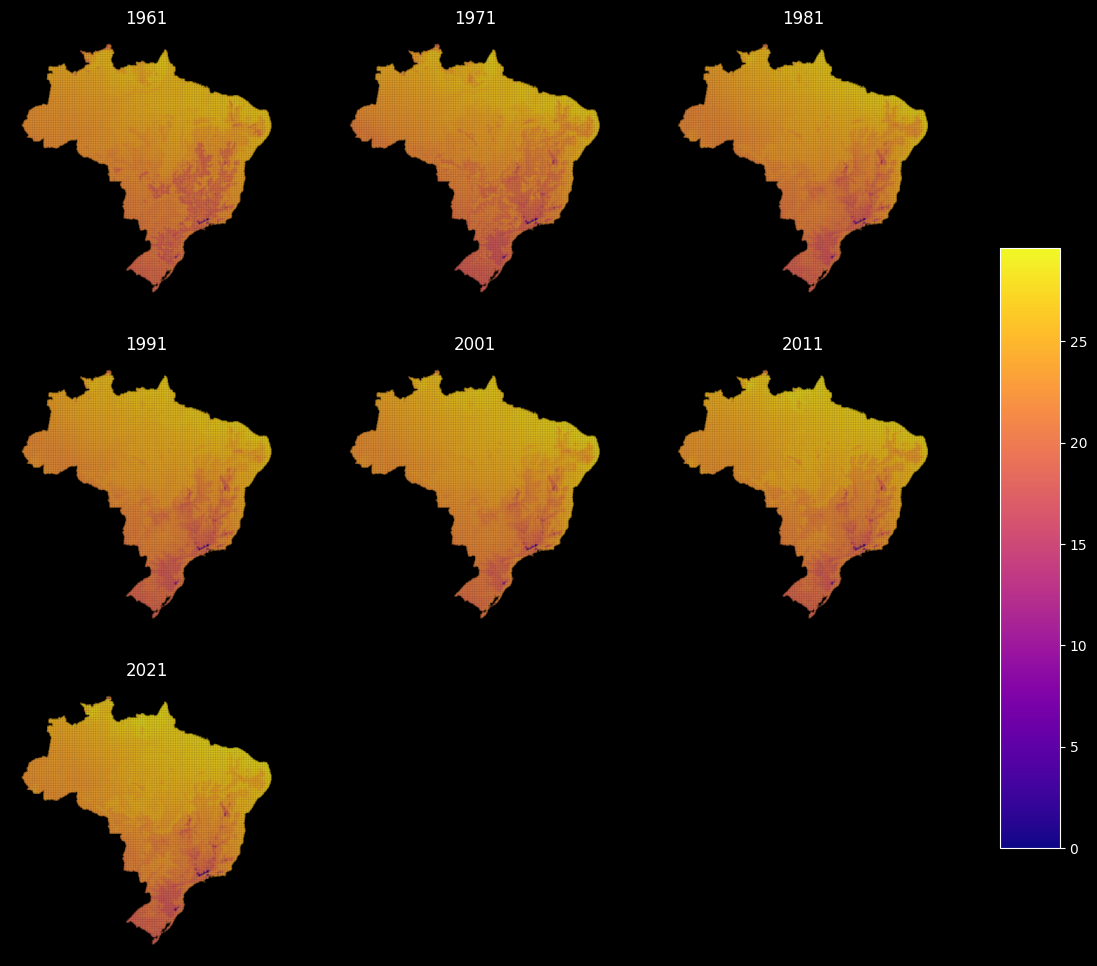

In [77]:
plt.rcParams['figure.figsize'] = (12, 12)
fig, axs = plt.subplots(nrows=3, ncols=3)

cmap = 'plasma'

for ax in axs.flat:
    ax.set_axis_off()

cols = [col for col in years_pd.columns if 'estimate' in col and col.endswith('1')]

vmin = np.amin(years_pd[cols].to_numpy().reshape(-1))
vmax = np.amax(years_pd[cols].to_numpy().reshape(-1))

for ax, col in zip(axs.flat, cols):
    df = years_pd[col]
    df = df.reset_index()
    gdf = gp.GeoDataFrame(
        df, 
        geometry=gp.points_from_xy(
            x=df.vl_longitude, 
            y=df.vl_latitude
        )
    )
    ax.set_axis_on()

    ax = gdf.plot(
        column=col, 
        cmap=cmap, 
        vmin=vmin, 
        vmax=vmax, 
        ax=ax,
        legend=False,
        markersize=.01
    )

    ax.axis('off')
    ax.set_title(col.split('_')[-1])

scalar_map = mpl.cm.ScalarMappable(
    norm=colors.Normalize(vmin, vmax), 
    cmap=cmap
)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.20, 0.05, 0.5])

plt.colorbar(scalar_map, cax=cbar_ax)

plt.savefig('out/years_estimates_by_decade.png')
# plt.close()

With estimates for each year, we can compare average temperature maps, like these seven maps depicting the first year of each decade since the 1960's.

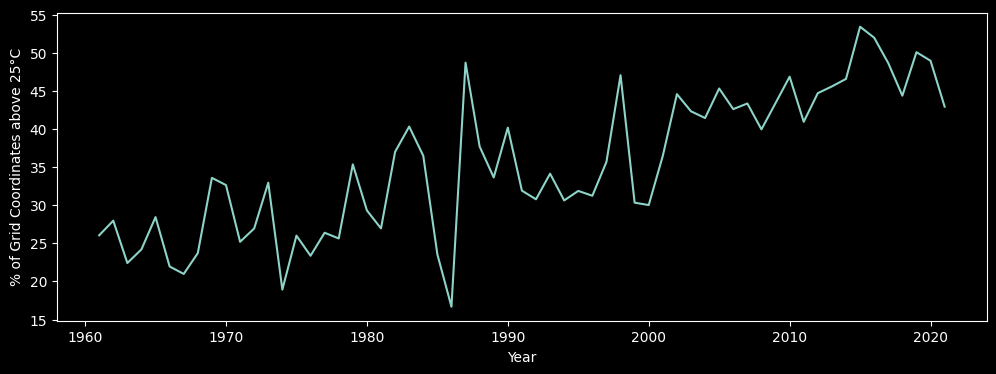

In [73]:
cols = [col for col in years_pd.columns if 'estimate' in col]

rows = years_pd.shape[0]

counts = {
    int(col.split('_')[-1]): 
    100 * sum(cell > 25 for cell in years_pd[col]) / rows
    for col in cols
}

plt.rcParams['figure.figsize'] = (12, 4)
ax = pd.Series(counts).plot()
yl = ax.set_ylabel('% of Grid Coordinates above 25°C')
xl = ax.set_xlabel('Year')

We can also count the number of grid coordinates which are above a certain critical temperature.
Divided by the total number of grid points, this gives a rough estimate of the percentage of the total area of Brazil which is, on average, above this critical temperature.
This plot thus shows that the percent area of the Brazilian territory which is on average above 25°C more than doubled since 1961.

In [50]:
# 
br_q = br.session.query(br.UF)
brasil = gp.read_postgis(br_q.statement, br.connect, 'geometria')


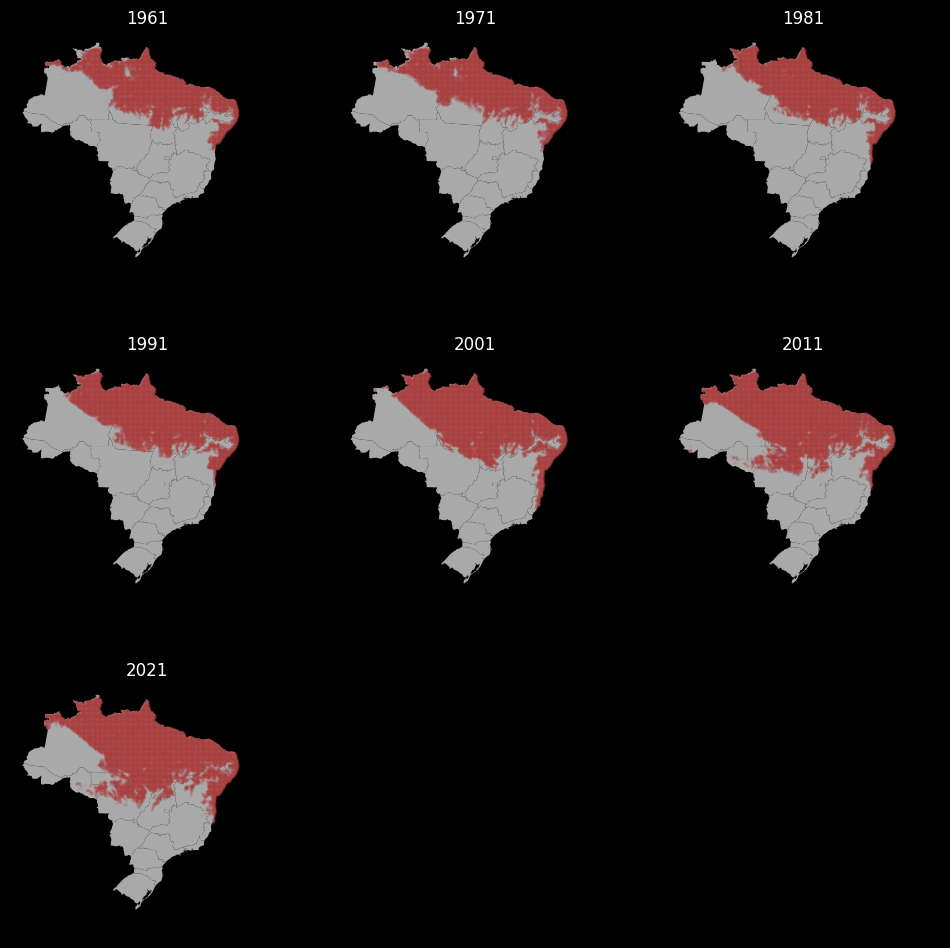

In [84]:

plt.rcParams['figure.figsize'] = (12, 12)
fig, axs = plt.subplots(nrows=3, ncols=3)

for ax in axs.flat:
    ax.set_axis_off()

cols = [col for col in years_pd.columns if 'estimate' in col and col.endswith('1')]

for ax, col in zip(axs.flat, cols):
    df = years_pd[col]
    df = df.reset_index()
    gdf = gp.GeoDataFrame(
        df, 
        geometry=gp.points_from_xy(
            x=df.vl_longitude, 
            y=df.vl_latitude
        )
    )

    gdf = gdf.query(f'{col} > 25')

    ax.set_axis_on()

    ax = brasil.plot(color='darkgrey', ax=ax)

    ax = gdf.plot(
        column=col, 
        color='#AA4040',
        vmin=vmin, 
        vmax=vmax, 
        ax=ax,
        legend=False,
        markersize=.01
    )

    ax.axis('off')
    ax.set_title(col.split('_')[-1])

scalar_map = mpl.cm.ScalarMappable(
    norm=colors.Normalize(vmin, vmax), 
    cmap=cmap
)

plt.savefig('out/percent_areas.png')
# plt.close()

These maps depict the increase in areas above 25°C average temperature on the first year of each decade.
It is clear that this increase is happening most over the states at the frontier of deforestation over the Amazon forest.